In [1]:
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%cd /home/jeroen/repos/traffic-scheduling/

/home/jeroen/repos/traffic-scheduling


## Direct transcription for general objectives

In [3]:
ampl = AMPL()
ampl.eval(r"""
param N; # number of lanes
param n {1..N}; # number of vehicles per lane
param nmax = max {l in 1..N} n[l];
set Ns = { l in 1..N, k in 1..nmax : k <= n[l] }; # vehicle indices

param T; # number of discrete time steps
param dt; # discrete time step size
set Ts = 0..T; # step indices

param eps; # minimum control input

# objective parameters
param Q;
param R;
param vd;

# intersection and follow distances
param L;
param H;
param P;

# state and control variables
var p {Ns, Ts}; # position
var v {Ns, Ts}; # velocity
var u {Ns, Ts}; # control (acceleration)

param p0 {Ns}; # initial position
param v0 {Ns}; # initial velocity

# conjunctive/disjunctive pairs
set C = {(l1,k1) in Ns, (l2,k2) in Ns: l1 == l2 and k2 = k1 + 1};
set D = {(l1,k1) in Ns, (l2,k2) in Ns: l1 <> l2};

# decision variables for the disjunctive constraints
var delta {Ns, Ts} binary;
var gamma {Ns, Ts} binary;

# big-M
param M;

var f {(i,k) in Ns, t in Ts} = Q*(vd - v[i, k, t])^2 + R*(u[i, k, t]);
minimize Objective: sum {(i,k) in Ns} dt*(0.5*f[i, k, 0] + 0.5*f[i, k, T] + (sum {t in 1..T-1} f[i, k, t]));

subject to p_initial {(i,k) in Ns}: p[i, k, 0] = p0[i, k];
subject to v_initial {(i,k) in Ns}: v[i, k, 0] = v0[i, k];

subject to u_bounds {(i,k) in Ns, t in Ts}: -3 <= u[i, k, t] <= 3;
subject to v_min {(i,k) in Ns, t in Ts}: v[i, k, t] >= eps;

# forward Euler
subject to integrate_p {(i,k) in Ns, t in 0..T-1}: p[i, k, t+1] = p[i, k, t] + dt*v[i, k, t];
subject to integrate_v {(i,k) in Ns, t in 0..T-1}: v[i, k, t+1] = v[i, k, t] + dt*u[i, k, t];

# disjunctive constraints
subject to disjunctive_1 {(i,k) in Ns, t in 0..T}: p[i, k, t] <= L + delta[i, k, t] * M;
subject to disjunctive_2 {(i,k) in Ns, t in 0..T}: H - gamma[i, k, t] * M <= p[i, k, t];
subject to disjunctive_3 {(i1,k1,i2,k2) in D, t in 0..T}: delta[i1,k1, t] + delta[i2,k2, t] + gamma[i1,k1, t] + gamma[i2,k2, t] <= 3;

# follow constraints
subject to follow {(i1,k1,i2,k2) in C, t in 0..T}: p[i1,k1, t] - p[i2,k2, t] >= P;
""")

instance = {
    'p0': [[15, 10,  0], [10,  0]],
    'v0': [[10, 10, 10], [10, 10]],
    'L': 30,
    'H': 40,
}

N = len(instance['p0'])
ampl.param["N"] = N
ampl.param["n"] = [len(instance['p0'][i]) for i in range(N)]

# initial positions
ampl.param["p0"] = [x for xs in instance['p0'] for x in xs]
ampl.param["v0"] = [x for xs in instance['v0'] for x in xs]

# intersection intervals
ampl.param["L"] = instance["L"]
ampl.param["H"] = instance["H"]
ampl.param["P"] = 5

ampl.param["T"] = 120
ampl.param["dt"] = 0.1
ampl.param["eps"] = 0.01
ampl.param["Q"] = 1
ampl.param["R"] = 1
ampl.param["vd"] = 20

# big-M
ampl.param["M"] = 1000

ampl.solve(solver="scip")
assert ampl.solve_result == "solved"

p = ampl.get_variable("p").to_pandas()

SCIP 9.0.1: WARNING: No dual information available when presolving was performed.
SCIP 9.0.1: optimal solution; objective 1274.416506
100290 simplex iterations
5 branching nodes


Make a "split" plot, where the vehicle trajectories from two incoming lanes are shown incoming from above and below a central marked intersection area.

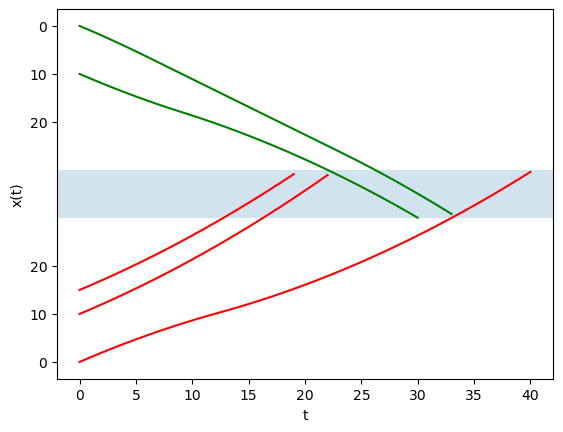

In [4]:
fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
# plot the intersection region
plt.axhspan(instance['L'], instance['H'], alpha=0.2)

# split axis and invert ticks
step = 10
ticks = np.arange(0, instance['L'], step)
double_ticks = np.concat([ticks, instance['H'] + step + np.flip(ticks)])
labels = np.concat([ticks, ticks])
plt.yticks(ticks=double_ticks, labels=labels)

for index, df in p.groupby(['index0', 'index1']):
    l = index[0]
    k = index[1]
    if l == 1:
        plt.plot(df[df < instance['H']].to_numpy(), color='r')
    elif l == 2:
        offset = (instance['H'] + instance['L']) / 2
        plt.plot(2*offset - df[df < instance['H']].to_numpy(), color='g')

plt.savefig('motion/trajectories_general.pdf')
plt.show()